In [3]:
BATCH_SIZE=50
CROP_SIZE=256

TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
NOISE_WEIGHT = .6

VALIDATION_PCT = .2
RANDOM_SEED = 42
SHUFFLE_DATASET = False

ITERATIONS=10

In [4]:
import sys
sys.path.append("..")

from IPython.display import clear_output
%matplotlib inline

import logging
import numpy as np
from numpy import inf
from skimage.metrics import structural_similarity as ssm
from scipy.special import factorial
from matplotlib import pyplot as plt


import torch
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
import torch.nn as nn
from torch.nn import MSELoss
from torch.autograd import Variable
from torch.optim import Adam
import torch.nn.functional as f
from torch.autograd import Variable



import torchvision
from torchvision import transforms


from models.RIM_v3 import RIM
from util import show, plot_images, plot_tensors

In [5]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.batch_size=batch_size

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / self.batch_size % self.batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)
    
  

class log_funcs():
    def __init__(self, updated, noise_ref, h,noise_weight):
        self.updated=updated
        self.noise_ref=noise_ref
        self.h=h
        self.noise_weight=noise_weight

    def poisson_log(Ax, b):
        # from https://stanford.edu/class/ee367/reading/lecture10_notes.pdf
        term1 = np.log(Ax)*b
        term2 = Ax
        term3 = torch.from_numpy(np.log(factorial(b)))
        
        loglikelihood = term1 - term2 - term3
        loglikelihood[np.isnan(loglikelihood)==True]=-10000000
        loglikelihood[np.isinf(loglikelihood)==True]=-10000000
        return loglikelihood[0]
    
    def gradient(updated, noise_ref, h, noise_weight):
        grad_ll = []
        zero_matrix = torch.zeros([noise_ref.shape[2], noise_ref.shape[3]], dtype=torch.double)
        
        ll_sum=zero_matrix.detach()
        llh_sum=zero_matrix.detach()

        for i, b in enumerate(noise_ref):
            x = updated[i]
            x_plus = updated[i]+h
            Ax = add_noise(x,noise_weight,'Poisson')
            Ax_plus = add_noise(x_plus,noise_weight,'Poisson')
            
                               
            
            # Poisson log-likelihood
            loglikelihood = log_funcs.poisson_log(Ax, b)
            loglikelihood_plus = log_funcs.poisson_log(Ax_plus, b)

        
            grad=(loglikelihood_plus-loglikelihood)/h
            grad_ll.append(grad)
            
        return torch.stack(grad_ll).unsqueeze(1).float()


        
def add_noise(clean_images,noise_weight,noise_type):
    clean_np = np.clip(clean_images.detach().numpy(),0,1)

    if 'Poisson' in noise_type:
        noise_mask = np.random.poisson(clean_np)
    else:
        noise_mask= clean_np*0

    noisy_images = torch.clamp(torch.from_numpy(clean_np+(noise_mask*noise_weight)),0,1).float() 
    return noisy_images


def live_plot(data, figsize=(7,5), title=''):
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    clear_output(wait=True)
    plt.show();

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# load and sort dataset
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(CROP_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(
    root=GT_DATA_PATH, transform=TRANSFORM_IMG)

newdataset = gtmatch(train_data, gt_data, BATCH_SIZE)

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(VALIDATION_PCT * dataset_size))


train_indices, val_indices = indices[split:], indices[:split]

if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    
# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=BATCH_SIZE, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler)

In [8]:
model = RIM()
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)

## RIM

In [ ]:
losses = []
avg_grad_logs = []
val_losses = []
best_val_loss = 1
loss = 'null'

data_loader = train_loader


for i, batch in enumerate(data_loader):
    model.train()

    clean_images, gt = batch
    noisy_images = add_noise(clean_images,NOISE_WEIGHT,'Poisson')
    input_images = noisy_images
    grad_log=torch.zeros(noisy_images.shape)
    st1=0
    st2=0
    
    for j in range(0, ITERATIONS):
        #xt
        net_input=torch.cat([input_images, grad_log], dim=1)
        
        net_output, st1, st2=model(net_input, st1, st2, j)
        
        #xt+1 = xt + Δx
        pred_images=input_images+net_output
                
        grad_log =log_funcs.gradient(pred_images.detach(),noisy_images,.0001,NOISE_WEIGHT)
        
        loss=loss_function(pred_images,clean_images)
        
        
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        avg_grad_logs.append(torch.mean(grad_log).item())
        

        
        #xt+1 -> xt

        input_images= pred_images
        
        plot_tensors([clean_images[0,0],noisy_images[0,0],pred_images[0,0],grad_log[0,0]])

        live_plot(losses,title=loss.item())

In [35]:
model_output = []
Input_PSNR = []
Model_PSNR = []

model_output = []
Input_PSNR = []
Model_PSNR = []
Model_loss = []
clipped_model_loss = []

for i, batch in enumerate(train_loader):


    clean_images, gt = batch
    
    noisy_images = add_noise(clean_images,NOISE_WEIGHT,'Poisson')
    net_input=torch.cat([noisy_images, grad_log], dim=1)

    model.eval()

    denoised = -model(net_input, st1, st2, 0)[0].detach()
    denoised_arr = np.clip(denoised.cpu().numpy()[
        0, 0].astype(np.float64),0,1)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)
    Input_PSNR.append(ssm(clean_comp, net_input_np))
    Model_PSNR.append(ssm(clean_comp, denoised_arr))
    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), gt])

    Model_loss.append(loss_function(denoised, clean_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), clean_images))
    
    if i>2:
        break

Input SSIM =  0.48
Simple RIM SSIM =  0.5907

Simple RIM Loss =  tensor(0.0130)
Clipped Simple RIM Loss =  tensor(0.0091, dtype=torch.float64)


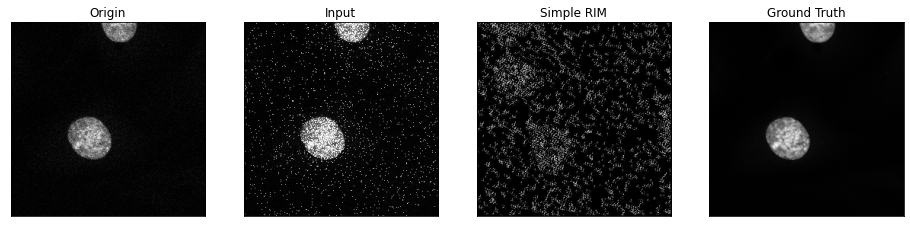

In [36]:
idx=1
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM","Ground Truth"])
print("Input SSIM = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM SSIM = ", np.round(Model_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))

In [25]:
print("Average Input SSIM = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM SSIM = ", np.round(np.mean(Model_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))

Average Input SSIM =  0.47
Average Simple RIM SSIM =  0.4699

Average Simple RIM Loss =  0.0156
Average Clipped Simple RIM Loss =  0.0169


## RIM with J-Invariant Mask

In [ ]:
from mask_RIM_v3 import Masker
masker = Masker(width=4, mode='interpolate')

data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_Jimages = []
best_val_loss = 1
st1=0
st2=0

for j in range(0,5):
    
    print(j)

    for i, batch in enumerate(data_loader):
        clean_images, gt = batch

        noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*noise_weight
        gaussian=torch.randn(clean_images.size())*noise_weight
        noisy_images=clean_images+noise
        


        model.train()


        if i==0:
            loglikelihood=torch.zeros(noisy_images.shape)
            
        net_input=torch.cat([noisy_images, loglikelihood],dim=1)

            
        net_input, mask = masker.mask(net_input, i % (masker.n_masks - 1))


        net_output, st1, st2 = model(net_input, st1, st2, i, j)
        
        st1=st1.detach()
        st2=st2.detach()


        pred_image=net_output+noisy_images
        loglikelihood=(pred_image+noise)-noisy_images
        loglikelihood=loglikelihood.detach()

        loss = loss_function(pred_image*mask, noisy_images*mask)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        model.eval()
        val_loss = loss_function(pred_image*mask, noisy_images*mask)
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = noisy_images+model(net_input, st1, st2, i, j)[0].detach()
            Jinv = noisy_images + \
                masker.infer_full_image(net_input, model, st1, st2, i, j)[0].detach()
            Jinv = np.clip(Jinv, 0, 1).cpu().numpy()[
                0, 0].astype(np.float64)
            net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
            denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
                0, 0].astype(np.float64)
            clean_comp = clean_images.detach().cpu().numpy()[
                0, 0].astype(np.float64)

            best_psnr = compare_psnr(clean_comp, Jinv)

            noisy_input.append(net_input_np)
            best_images.append(denoised_arr)
            best_Jimages.append(Jinv)
            clean_image_corr.append(clean_images)
            print("Loss (", i,"-",j, "): \t", round(loss.item(), 4))
            print("\tModel PSNR: ", np.round(best_psnr, 2))

In [ ]:
model_output = []
Input_PSNR = []
Model_PSNR = []
JInv_PSNR = []
Model_loss = []
clipped_model_loss = []

JInv_loss = []
clipped_JInv_loss = []

for i, batch in enumerate(validation_loader):

    clean_images, gt = batch
    
    noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*noise_weight
    gaussian=torch.randn(clean_images.size())*noise_weight
    noisy_images=clean_images+noise

    model.eval()

    net_input=torch.cat([noisy_images, loglikelihood],dim=1)

    denoised = noisy_images+model(net_input, st1, st2, i, j)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)
    Jinv = noisy_images + \
        masker.infer_full_image(net_input, model, st1, st2, i, j)[0].detach()
    Jinv_np = np.clip(Jinv, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)

    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), torch.from_numpy(Jinv_np), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    JInv_PSNR.append(compare_psnr(clean_comp, Jinv_np))
    
    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))
    
    JInv_loss.append(loss_function(Jinv, noisy_images))
    clipped_JInv_loss.append(loss_function(
        torch.from_numpy(Jinv_np), noisy_images))

In [ ]:
idx=1
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM",
                               "J-Invariant RIM", "Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("J-Invariant RIM PSNR = ", np.round(JInv_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))
print("")
print("J-Invariant RIM Loss = ", np.round(JInv_loss[idx], 4))
print("Clipped J-Invariant RIM Loss = ", np.round(clipped_JInv_loss[idx], 4))

In [ ]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("Average J-Invariant RIM PSNR = ", np.round(np.mean(JInv_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))
print("")
print("Average J-Invariant RIM Loss = ", np.round(np.mean(JInv_loss), 4))
print("Average Clipped J-Invariant RIM Loss = ", np.round(np.mean(clipped_JInv_loss), 4))

In [ ]:
from scipy.special import gamma, factorial
[1,2,3]-sum(factorial([1,2,3]))


In [ ]:
[1,2,3]

In [ ]:
NaN